# t-Distributed Stochastic Neighbor Embedding (t-SNE)

Este notebook explora o t-SNE, uma técnica de redução de dimensionalidade não linear particularmente eficaz para a visualização de datasets de alta dimensão. Diferentemente de métodos como o PCA, que se concentram em preservar a variância global, o t-SNE foca em preservar a estrutura local, ou seja, as similaridades entre pontos vizinhos. Ele modela as similaridades entre pontos de dados tanto no espaço de alta dimensão quanto no de baixa dimensão e busca minimizar a divergência entre essas duas distribuições de similaridade.

## Fundamentação

O t-SNE opera em duas etapas principais: primeiro, ele constrói uma distribuição de probabilidade sobre pares de pontos de dados de alta dimensão, de modo que pontos similares tenham uma alta probabilidade de serem escolhidos, enquanto pontos dissimilares tenham uma probabilidade extremamente baixa. Segundo, ele define uma distribuição de probabilidade similar sobre os pontos no mapa de baixa dimensão e minimiza a divergência de Kullback-Leibler (KL) entre as duas distribuições em relação às localizações dos pontos no mapa.

### Similaridades no Espaço de Alta Dimensão

A similaridade entre os pontos de dados $x_i$ e $x_j$ é a probabilidade condicional, $p_{j|i}$, de que $x_i$ escolheria $x_j$ como seu vizinho se os vizinhos fossem escolhidos em proporção à sua densidade de probabilidade sob uma Gaussiana centrada em $x_i$. A probabilidade é dada por:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

A variância da Gaussiana, $\sigma_i^2$, é determinada para cada ponto de dados individualmente através de uma busca binária. Essa busca é realizada para encontrar um $\sigma_i$ que produza uma distribuição de probabilidade $P_i$ com uma perplexidade específica, um hiperparâmetro definido pelo usuário. A perplexidade pode ser interpretada como uma medida suave do número efetivo de vizinhos para cada ponto.

Para obter uma distribuição de probabilidade conjunta, o t-SNE simetriza essas probabilidades condicionais:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

onde $n$ é o número de pontos de dados.

### Similaridades no Espaço de Baixa Dimensão

No espaço de baixa dimensão (geralmente 2D ou 3D), o t-SNE utiliza uma distribuição t de Student com um grau de liberdade (que é equivalente a uma distribuição de Cauchy) para medir as similaridades entre os pontos de baixa dimensão $y_i$ e $y_j$. O uso de uma distribuição de cauda longa como a t de Student permite que pontos moderadamente distantes no espaço de alta dimensão sejam mapeados para distâncias maiores no espaço de baixa dimensão, ajudando a aliviar o problema de "crowding" (aglomeração). A probabilidade conjunta $q_{ij}$ é definida como:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

### Otimização via Minimização da Divergência KL

O objetivo do t-SNE é fazer com que a distribuição $Q$ (no espaço de baixa dimensão) reflita a distribuição $P$ (no espaço de alta dimensão) da melhor forma possível. Isso é alcançado minimizando a divergência de Kullback-Leibler entre as duas distribuições:

$$
C = \text{KL}(P||Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A minimização desta função de custo é realizada usando o método do gradiente descendente. O gradiente da divergência KL em relação aos pontos no embedding $y_i$ possui uma forma surpreendentemente simples, que é a diferença entre as forças de atração (puxando pontos similares para perto) e as forças de repulsão (empurrando pontos dissimilares para longe).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns

### Gerando um Dataset Sintético

Para demonstrar o t-SNE, vamos primeiro gerar um conjunto de dados sintético com clusters bem definidos. Usaremos a função `make_blobs` da biblioteca `scikit-learn`.

In [ ]:
n_samples = 300
n_features = 20
n_clusters = 5

X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=42,
    cluster_std=5.0
)

print("Formato do dataset X:", X.shape)
print("Formato do vetor y:", y.shape)

Formato do dataset X: (300, 20)
Formato do vetor y: (300,)


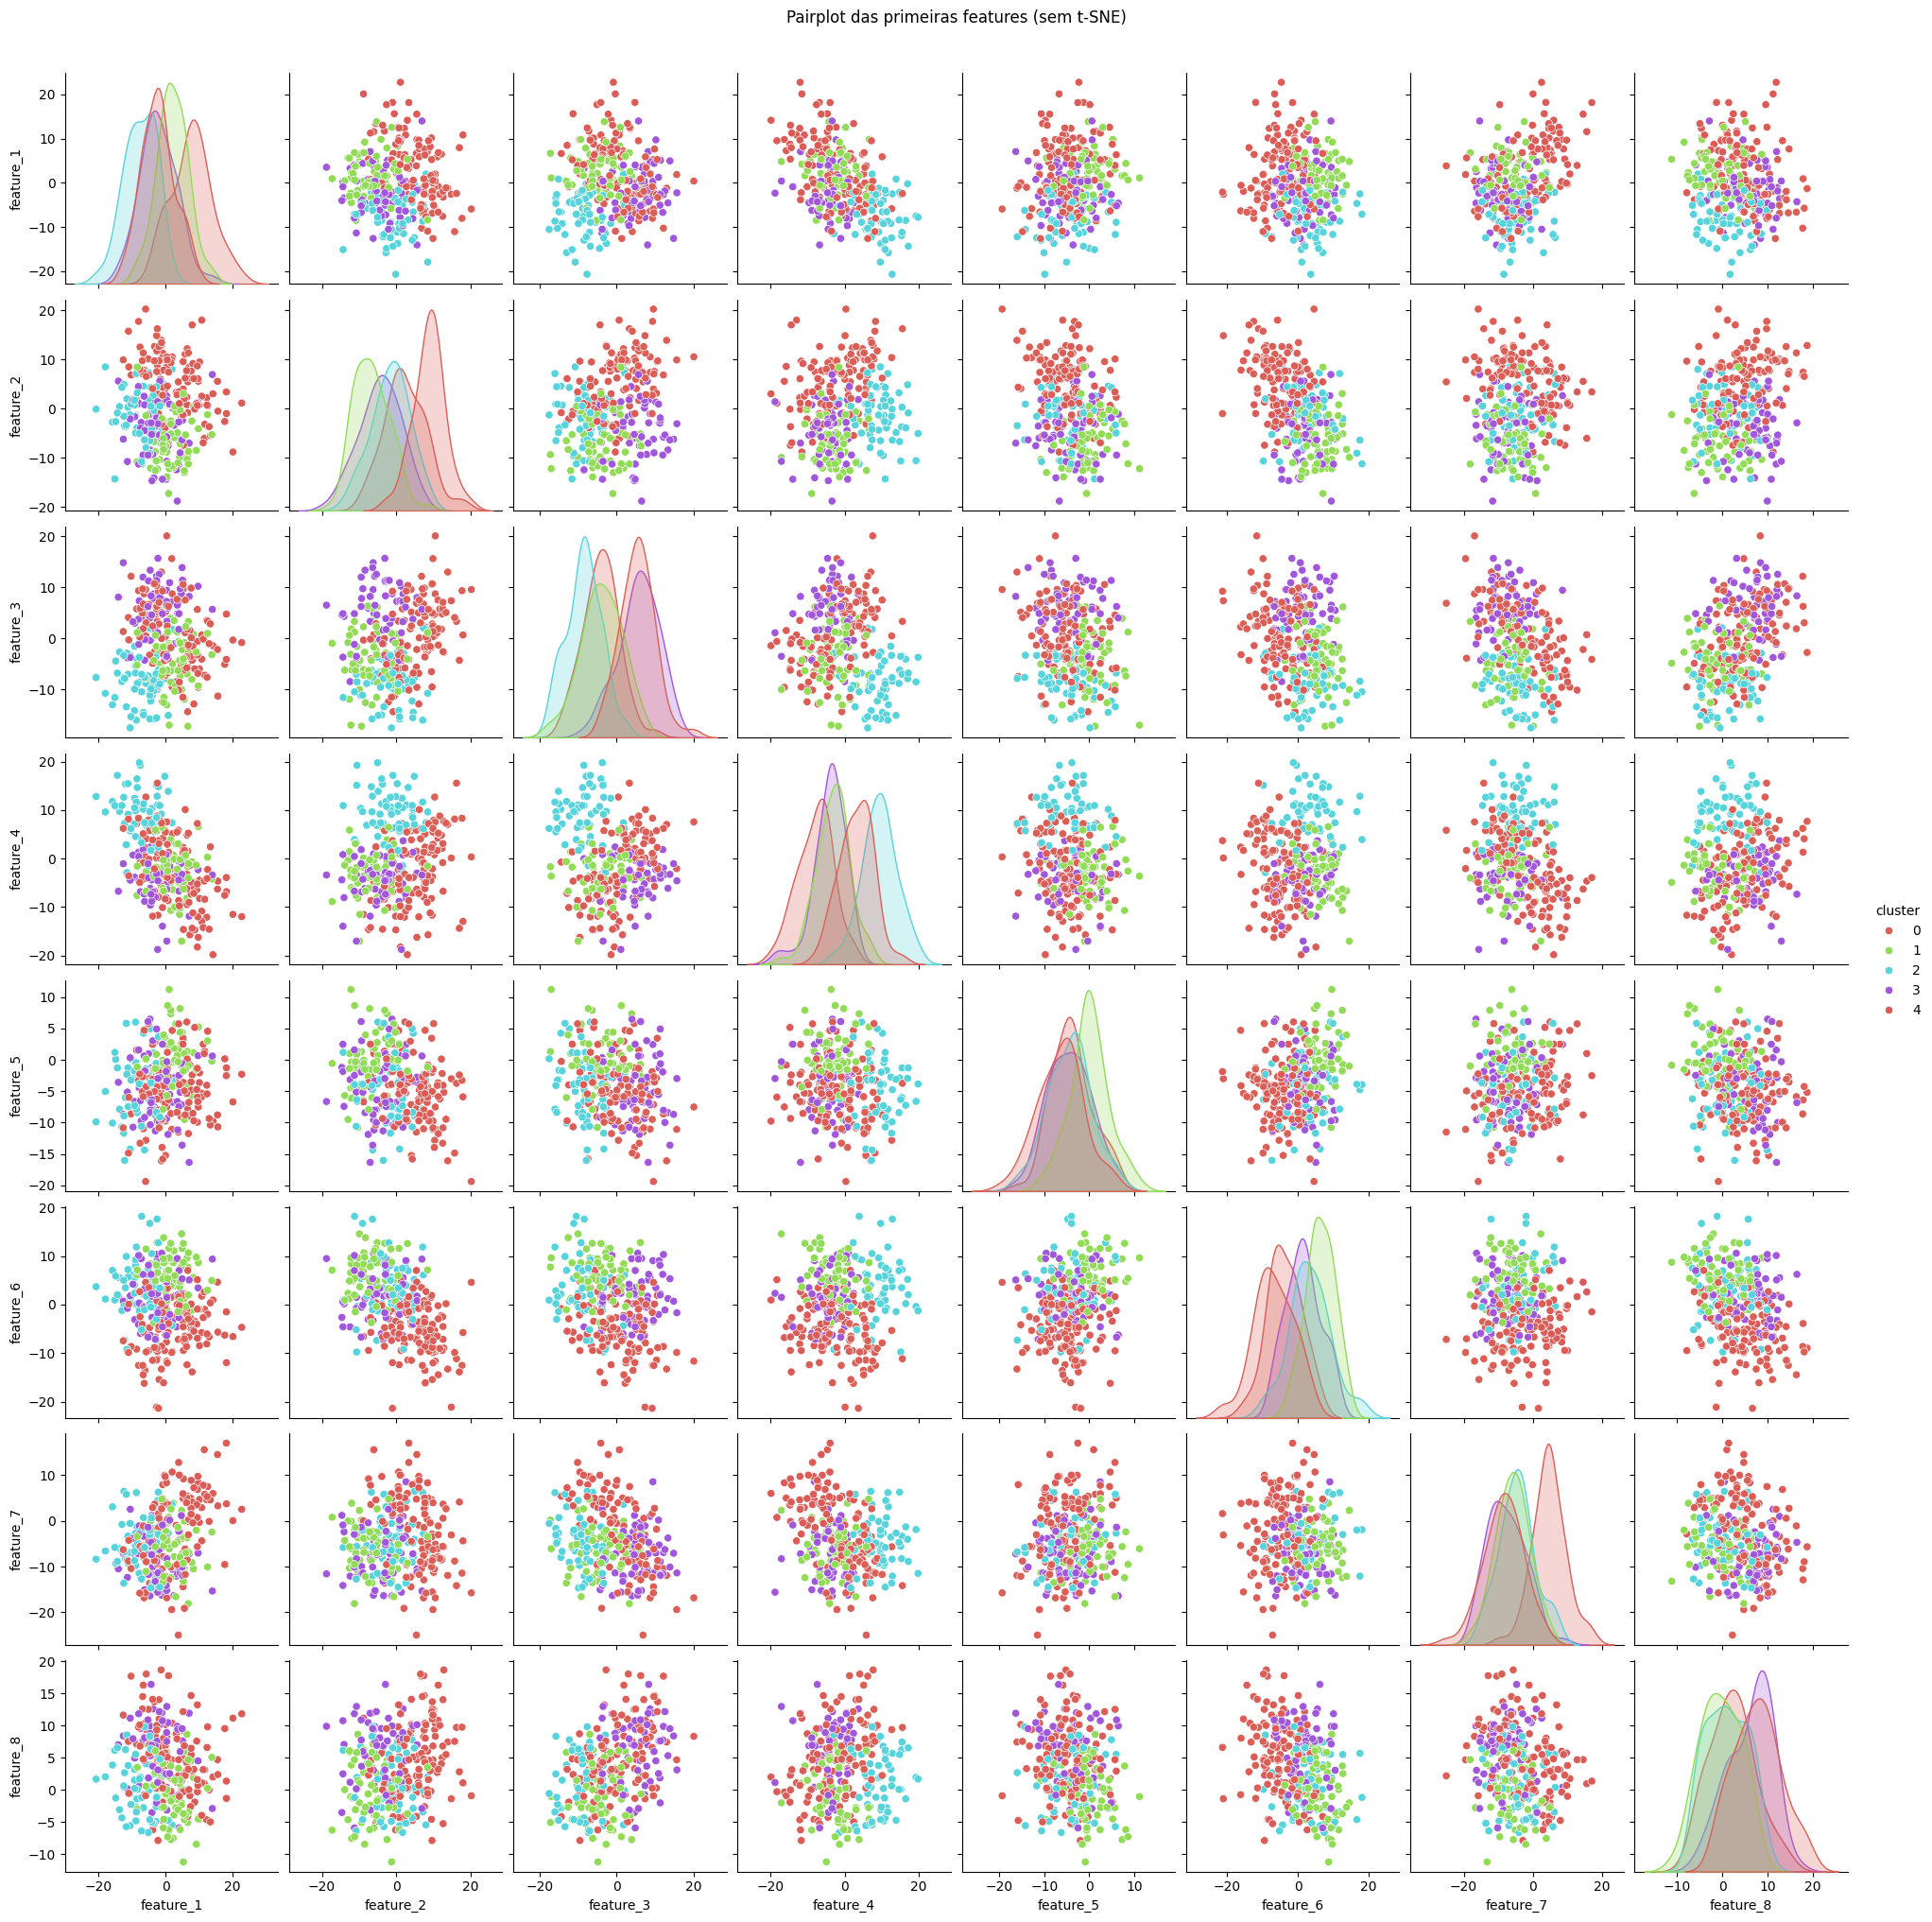

In [ ]:
df = pd.DataFrame(X[:, :8], columns=[f'feature_{i+1}' for i in range(8)])
df['cluster'] = y

sns.pairplot(df, hue='cluster', palette='hls')
plt.suptitle("Pairplot das primeiras features (sem t-SNE)", y=1.02)
plt.show()

## Implementação da Classe t-SNE

Agora, vamos implementar o algoritmo t-SNE, encapsulando a lógica em uma classe Python com uma interface similar à do `scikit-learn`. Esta implementação se concentrará na clareza do algoritmo, em vez de otimizações de performance.

In [ ]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, lr=200.0, n_iter=500):
        # Número de dimensões finais, perplexidade, taxa de aprendizado e iterações
        self.n_components = n_components
        self.perplexity = perplexity
        self.lr = lr
        self.n_iter = n_iter

    # -------------------------------------------------------
    # 1. Calcula matriz de distâncias euclidianas ao quadrado
    # -------------------------------------------------------
    def _distances(self, X):
        sum_X = np.sum(X**2, axis=1)
        return np.add(np.add(-2 * X @ X.T, sum_X).T, sum_X)

    # -------------------------------------------------------------------------
    # 2. Calcula a matriz P (probabilidades no espaço de alta dimensão)
    #    Cada linha P[i] é ajustada para ter uma entropia que corresponda à perplexidade
    # -------------------------------------------------------------------------
    def _p_matrix(self, D):
        n = D.shape[0]
        P = np.zeros((n, n))
        logU = np.log2(self.perplexity)

        for i in range(n):
            beta = 1.0  # inverso da variância (1 / (2*sigma²))
            Di = np.delete(D[i], i)  # remove a distância com ele mesmo

            # Ajuste de beta por busca simples até alcançar a perplexidade desejada
            for _ in range(30):
                P_i = np.exp(-Di * beta)
                P_i /= np.sum(P_i)
                H = -np.sum(P_i * np.log2(P_i + 1e-12))  # entropia
                if abs(H - logU) < 1e-3:  # se já está próximo, para
                    break
                beta *= 1.2 if H > logU else 0.8  # ajusta beta

            P[i, np.arange(n) != i] = P_i

        # Simetriza e normaliza
        P = (P + P.T) / (2 * n)
        return np.maximum(P, 1e-12)

    # -------------------------------------------------------
    # 3. Executa o t-SNE e retorna o embedding 2D
    # -------------------------------------------------------
    def fit_transform(self, X):
        n = X.shape[0]

        # Calcula afinidades no espaço original (P)
        D = self._distances(X)
        P = self._p_matrix(D)

        # Inicializa o embedding aleatoriamente
        Y = np.random.randn(n, self.n_components)

        # Loop de otimização
        for it in range(self.n_iter):
            # Calcula afinidades no espaço de baixa dimensão (Q)
            sum_Y = np.sum(Y**2, axis=1)
            num = 1 / (1 + np.add(np.add(-2 * Y @ Y.T, sum_Y).T, sum_Y))
            np.fill_diagonal(num, 0)
            Q = np.maximum(num / np.sum(num), 1e-12)

            # Calcula o gradiente
            PQ = P - Q
            for i in range(n):
                # Soma ponderada das diferenças (força de atração/repulsão)
                dY_i = np.sum((PQ[:, i] * num[:, i])[:, None] * (Y[i] - Y), axis=0)
                Y[i] -= self.lr * dY_i  # Atualiza posição

            # Centraliza os pontos
            Y -= np.mean(Y, axis=0)

            # Mostra custo a cada 100 iterações
            if (it + 1) % 100 == 0:
                cost = np.sum(P * np.log(P / Q))
                print(f"Iter {it+1:4d}: cost = {cost:.4f}")

        return Y

### Aplicando

Vamos agora instanciar nossa classe `TSNE` e aplicá-la ao mesmo dataset sintético. O processo de otimização será impresso, mostrando o valor da função de custo em intervalos regulares.

In [ ]:
custom_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_embedded_custom = custom_tsne.fit_transform(X)

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7569
Iter  200: cost = 0.6416
Iter  300: cost = 0.5956
Iter  400: cost = 0.5747
Iter  500: cost = 0.5615
Iter  600: cost = 0.5517
Iter  700: cost = 0.5446
Iter  800: cost = 0.5391
Iter  900: cost = 0.5346
Iter 1000: cost = 0.5309


### Visualizando o Resultado da Implementação

Finalmente, plotamos o resultado gerado pela nossa implementação.

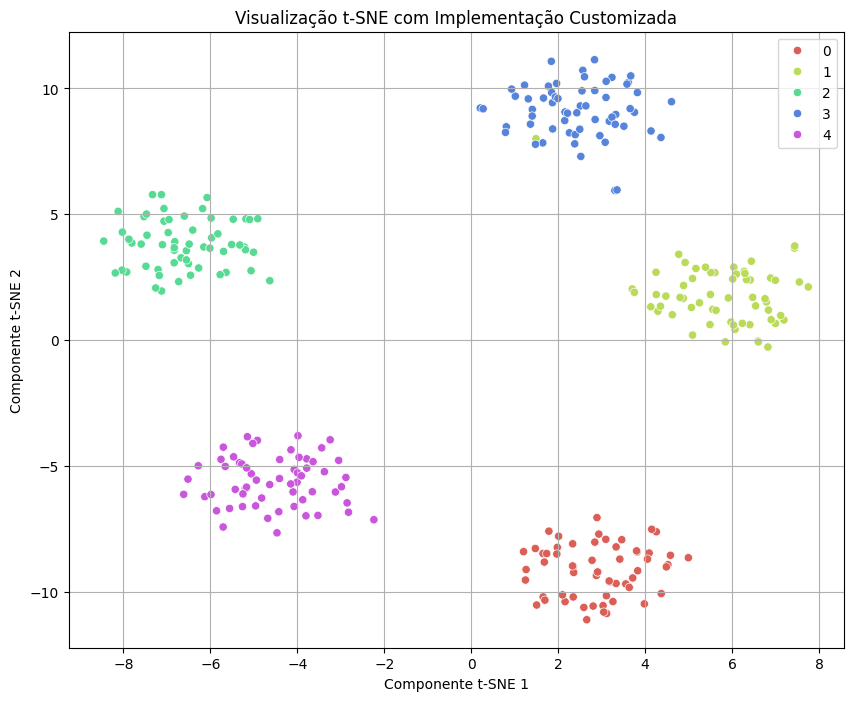

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y,
    palette=sns.color_palette("hls", n_clusters),
    legend="full"
)
plt.title('Visualização t-SNE com Implementação Customizada')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()

## Exercícios

### Exercício 1

Treine diferentes modelos t-SNE em 2D com diferentes valores de perplexidade para o dataset sintético e plote cada um deles.

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.9467
Iter  200: cost = 1.6696
Iter  300: cost = 1.5443
Iter  400: cost = 1.4582
Iter  500: cost = 1.3849
Iter  600: cost = 1.3349
Iter  700: cost = 1.2950
Iter  800: cost = 1.2666
Iter  900: cost = 1.2452
Iter 1000: cost = 1.2274


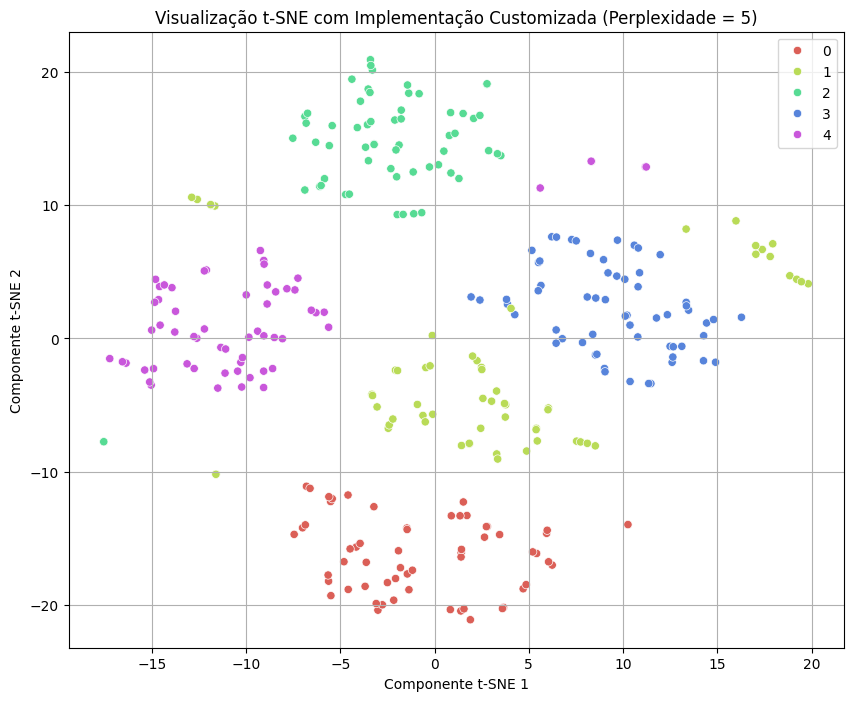

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.4984
Iter  200: cost = 1.2402
Iter  300: cost = 1.1377
Iter  400: cost = 1.0792
Iter  500: cost = 1.0427
Iter  600: cost = 1.0165
Iter  700: cost = 0.9962
Iter  800: cost = 0.9798
Iter  900: cost = 0.9662
Iter 1000: cost = 0.9546


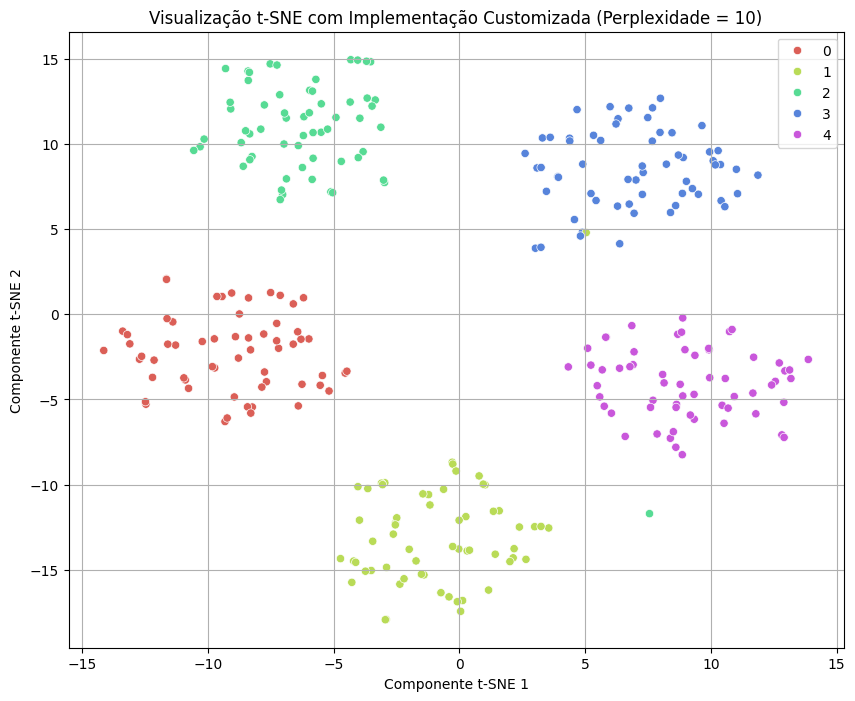

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.0137
Iter  200: cost = 0.8682
Iter  300: cost = 0.8154
Iter  400: cost = 0.7829
Iter  500: cost = 0.7619
Iter  600: cost = 0.7454
Iter  700: cost = 0.7294
Iter  800: cost = 0.7181
Iter  900: cost = 0.7103
Iter 1000: cost = 0.7039


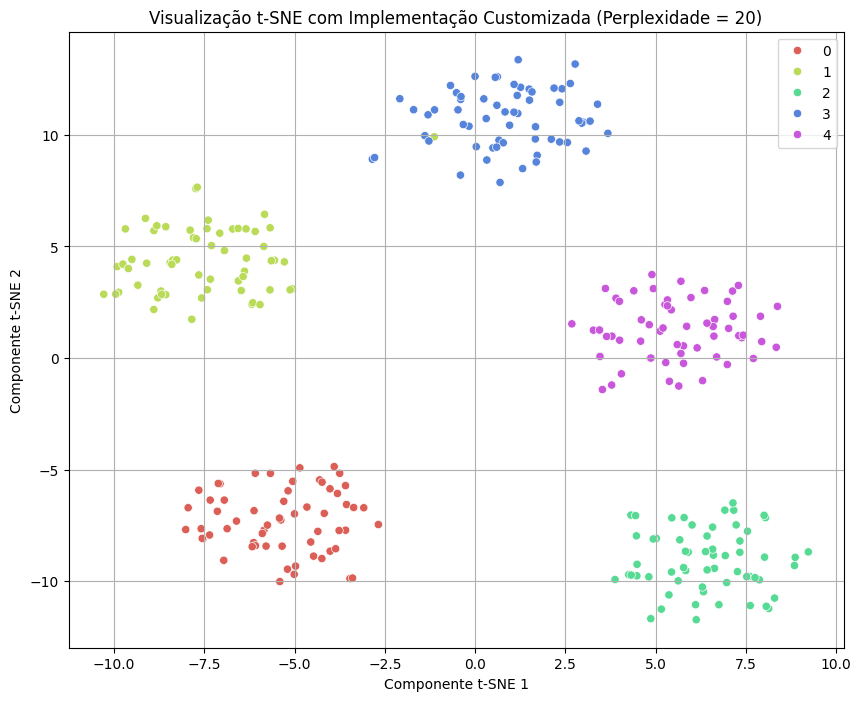

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7982
Iter  200: cost = 0.7035
Iter  300: cost = 0.6623
Iter  400: cost = 0.6395
Iter  500: cost = 0.6238
Iter  600: cost = 0.6128
Iter  700: cost = 0.6031
Iter  800: cost = 0.5778
Iter  900: cost = 0.5728
Iter 1000: cost = 0.5689


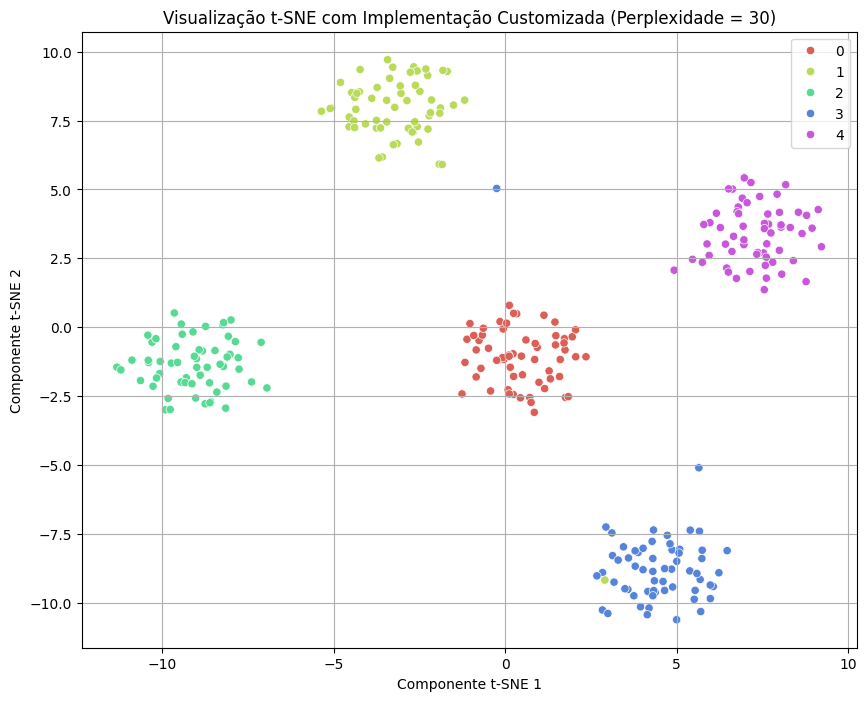

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.5894
Iter  200: cost = 0.5150
Iter  300: cost = 0.4900
Iter  400: cost = 0.4768
Iter  500: cost = 0.4680
Iter  600: cost = 0.4619
Iter  700: cost = 0.4576
Iter  800: cost = 0.4543
Iter  900: cost = 0.4516
Iter 1000: cost = 0.4496


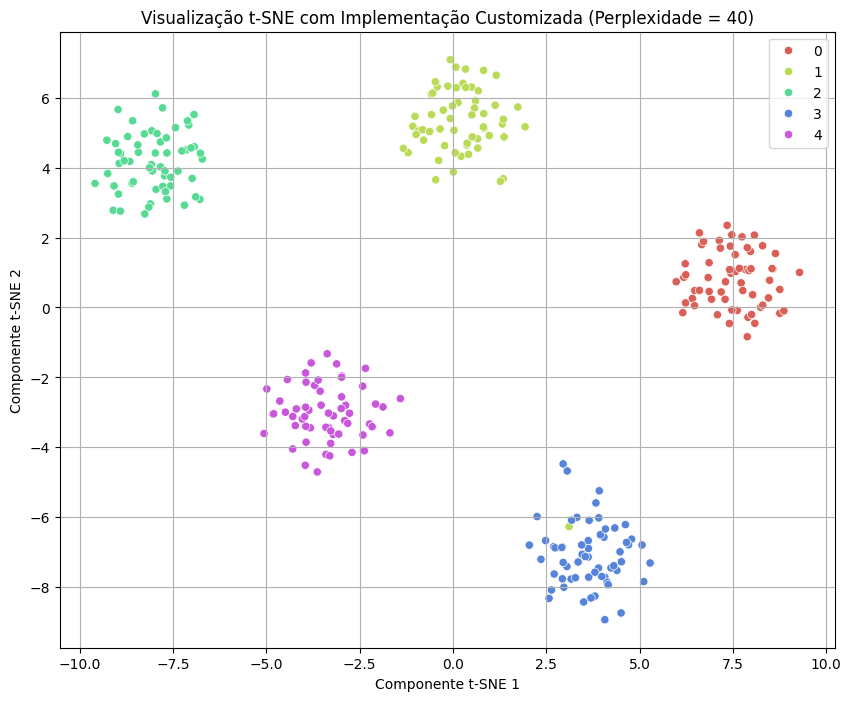

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.4363
Iter  200: cost = 0.3765
Iter  300: cost = 0.3565
Iter  400: cost = 0.3458
Iter  500: cost = 0.3393
Iter  600: cost = 0.3348
Iter  700: cost = 0.3313
Iter  800: cost = 0.3288
Iter  900: cost = 0.3269
Iter 1000: cost = 0.3253


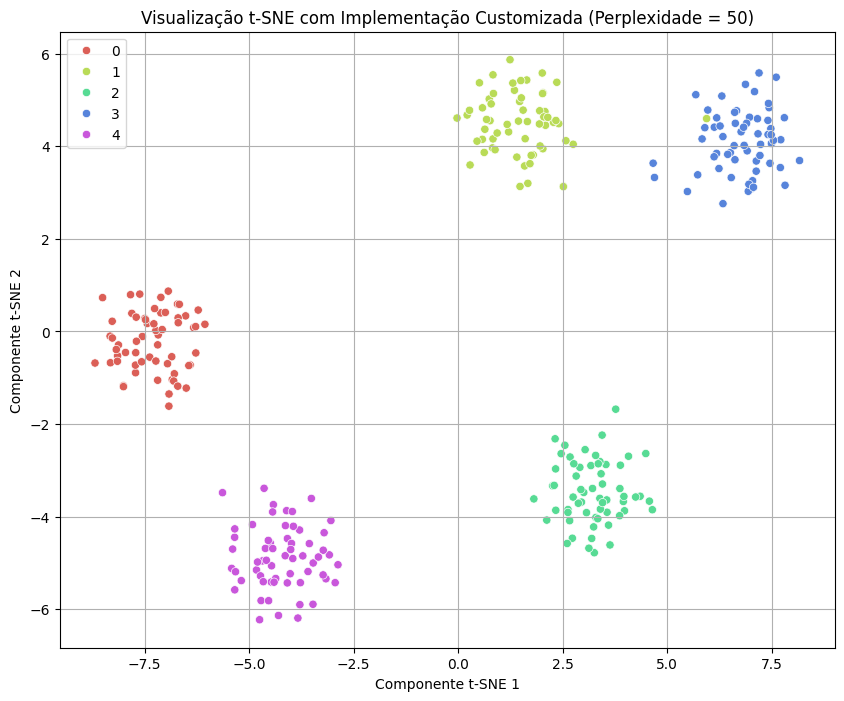

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.3880
Iter  200: cost = 0.3266
Iter  300: cost = 0.3064
Iter  400: cost = 0.2964
Iter  500: cost = 0.2905
Iter  600: cost = 0.2867
Iter  700: cost = 0.2842
Iter  800: cost = 0.2824
Iter  900: cost = 0.2810
Iter 1000: cost = 0.2800


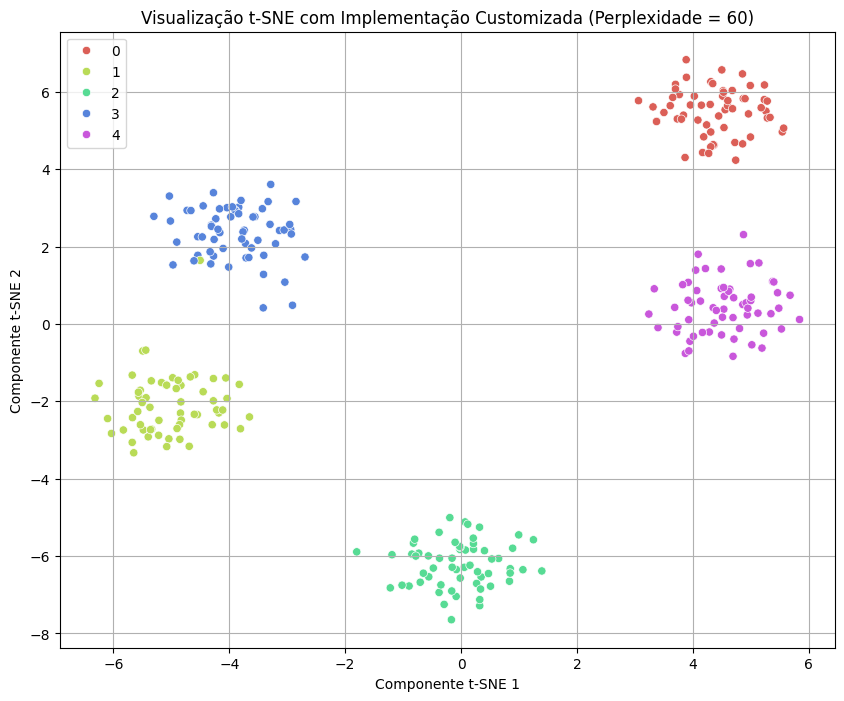

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.2950
Iter  200: cost = 0.2565
Iter  300: cost = 0.2465
Iter  400: cost = 0.2418
Iter  500: cost = 0.2390
Iter  600: cost = 0.2373
Iter  700: cost = 0.2359
Iter  800: cost = 0.2348
Iter  900: cost = 0.2339
Iter 1000: cost = 0.2333


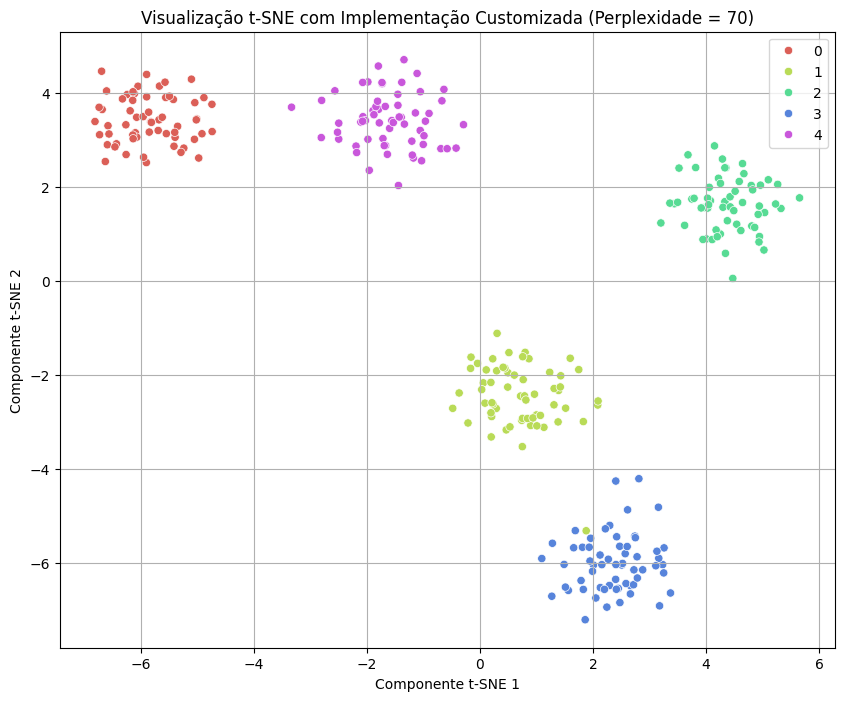

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.2667
Iter  200: cost = 0.2226
Iter  300: cost = 0.2122
Iter  400: cost = 0.2078
Iter  500: cost = 0.2057
Iter  600: cost = 0.2046
Iter  700: cost = 0.2039
Iter  800: cost = 0.2035
Iter  900: cost = 0.2032
Iter 1000: cost = 0.2030


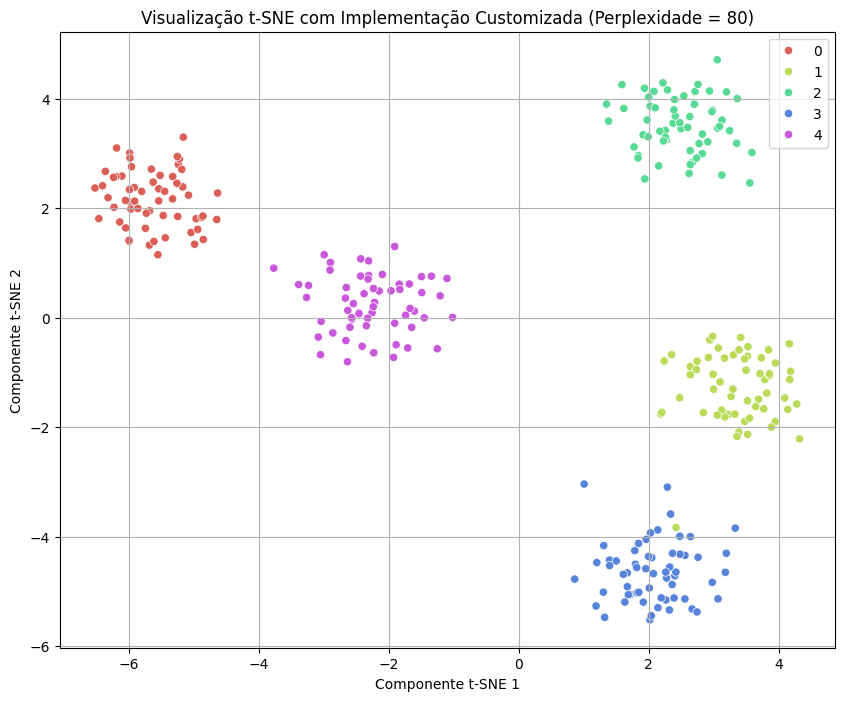

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.2569
Iter  200: cost = 0.2151
Iter  300: cost = 0.2038
Iter  400: cost = 0.1990
Iter  500: cost = 0.1969
Iter  600: cost = 0.1957
Iter  700: cost = 0.1949
Iter  800: cost = 0.1929
Iter  900: cost = 0.1920
Iter 1000: cost = 0.1914


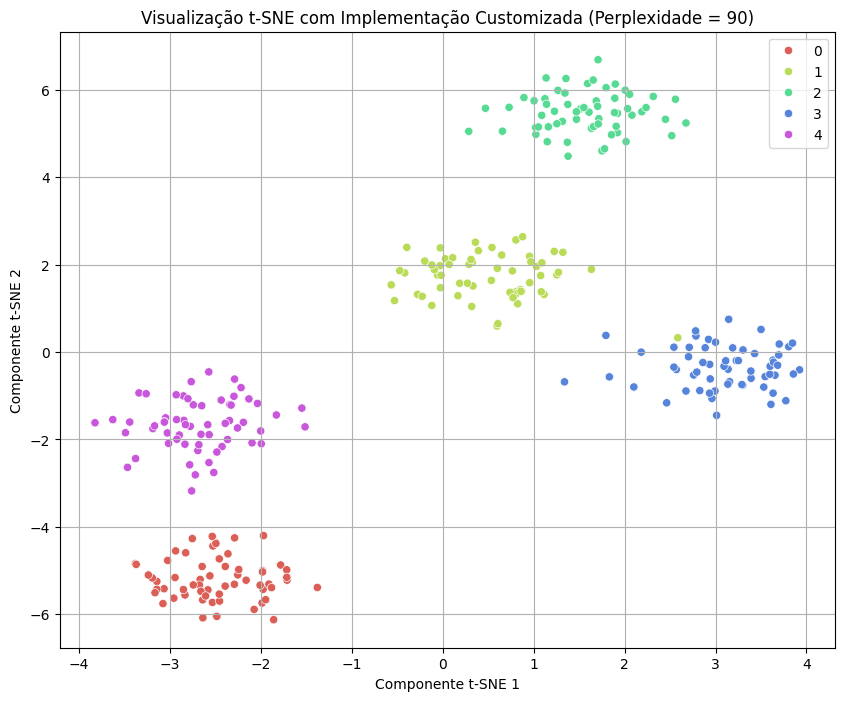

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.1938
Iter  200: cost = 0.1751
Iter  300: cost = 0.1706
Iter  400: cost = 0.1689
Iter  500: cost = 0.1680
Iter  600: cost = 0.1676
Iter  700: cost = 0.1674
Iter  800: cost = 0.1673
Iter  900: cost = 0.1672
Iter 1000: cost = 0.1671


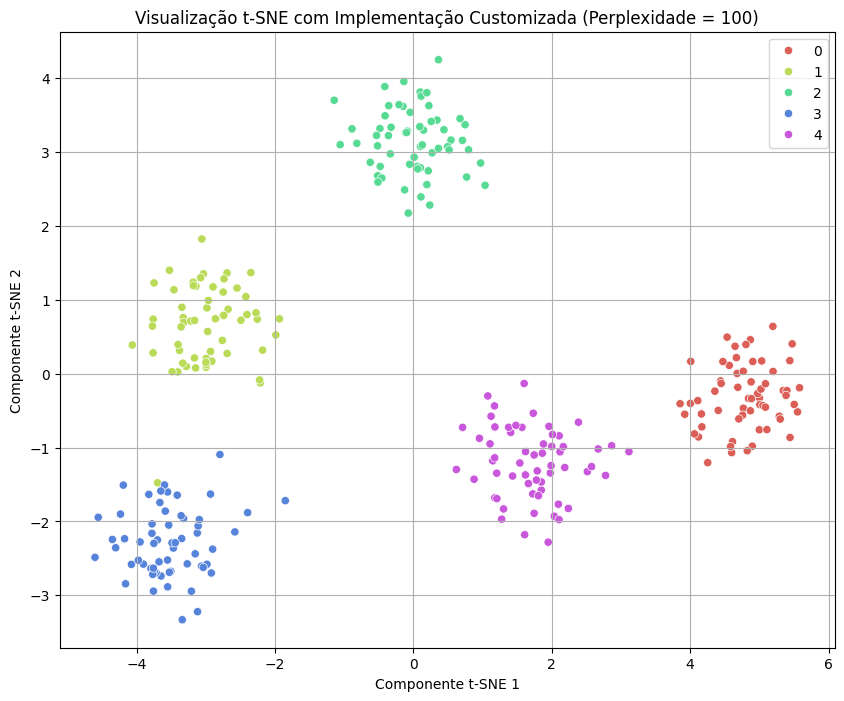

In [ ]:
# Perplexidade : de 5 a 100
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for perplexity in perplexities:
    custom_tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, lr=200)
    X_embedded_custom = custom_tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y,
    palette=sns.color_palette("hls", n_clusters),
    legend="full")

    plt.title('Visualização t-SNE com Implementação Customizada (Perplexidade = ' + str(perplexity) + ')')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.grid(True)
    plt.show()


### Exercício 2

Faça um treinamento de um modelo t-SNE para o Dataset Wine. Em seguida, plote o resultado em duas dimensões.

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Shape: {X_wine.shape}")
print(f"Features: {wine.feature_names}")
print(f"Classes: {wine.target_names}")

Dataset Wine:
Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.8744
Iter  200: cost = 0.7002
Iter  300: cost = 0.6216
Iter  400: cost = 0.5768
Iter  500: cost = 0.5465
Iter  600: cost = 0.5244
Iter  700: cost = 0.5071
Iter  800: cost = 0.4933
Iter  900: cost = 0.4817
Iter 1000: cost = 0.4717


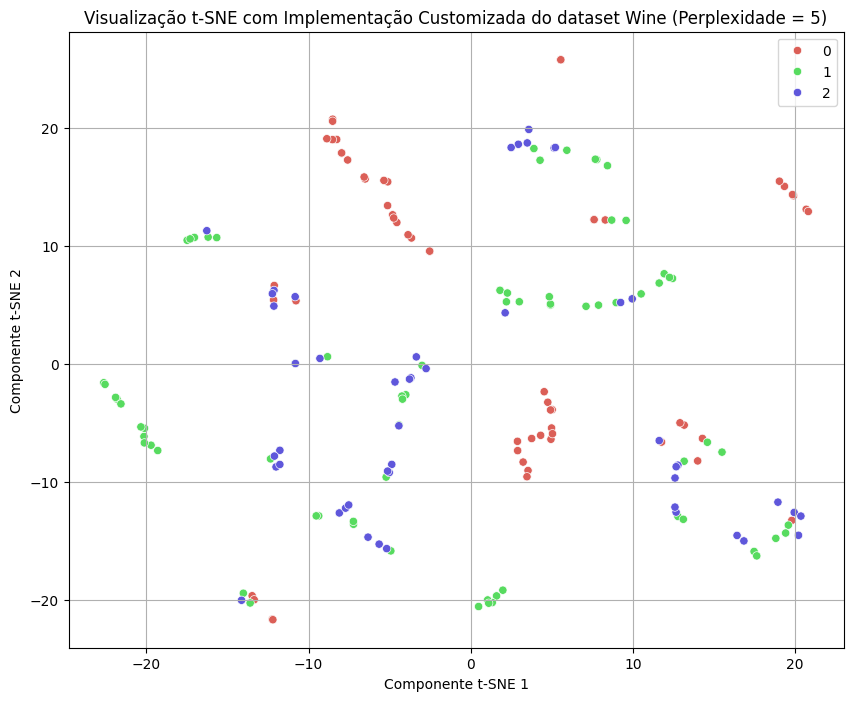

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.6371
Iter  200: cost = 0.5107
Iter  300: cost = 0.4580
Iter  400: cost = 0.4108
Iter  500: cost = 0.3890
Iter  600: cost = 0.3733
Iter  700: cost = 0.3612
Iter  800: cost = 0.3515
Iter  900: cost = 0.3436
Iter 1000: cost = 0.3369


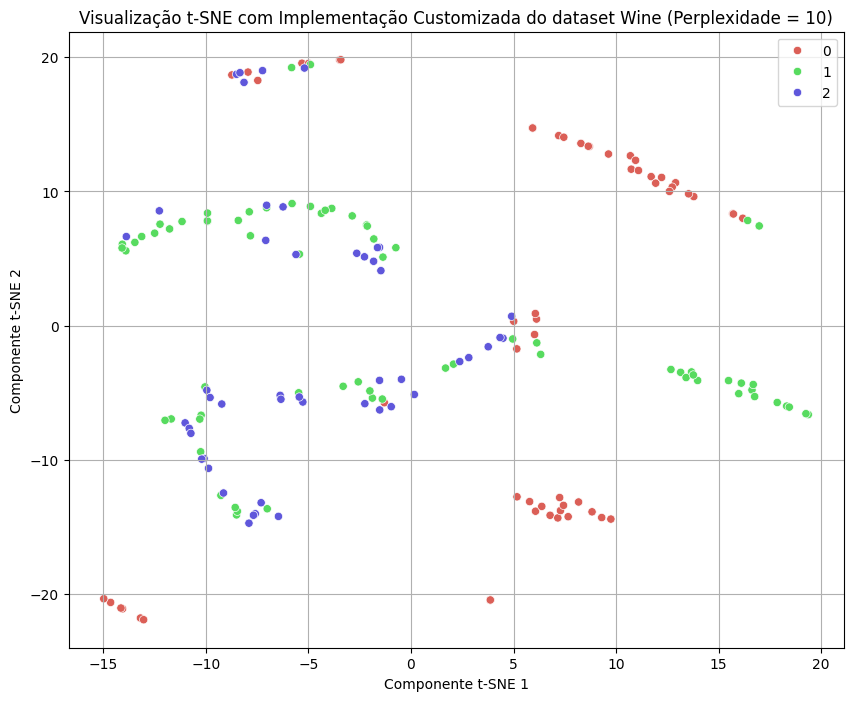

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.6653
Iter  200: cost = 0.5636
Iter  300: cost = 0.5178
Iter  400: cost = 0.4802
Iter  500: cost = 0.4356
Iter  600: cost = 0.4030
Iter  700: cost = 0.3637
Iter  800: cost = 0.3508
Iter  900: cost = 0.3410
Iter 1000: cost = 0.3328


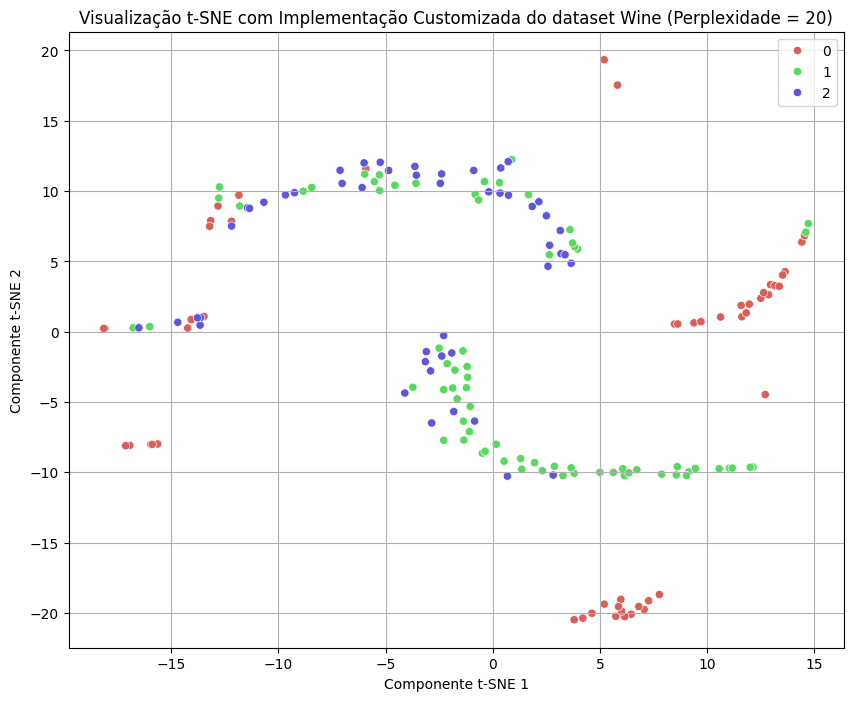

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.5506
Iter  200: cost = 0.4523
Iter  300: cost = 0.4097
Iter  400: cost = 0.3832
Iter  500: cost = 0.3598
Iter  600: cost = 0.3353
Iter  700: cost = 0.3241
Iter  800: cost = 0.3150
Iter  900: cost = 0.3074
Iter 1000: cost = 0.3009


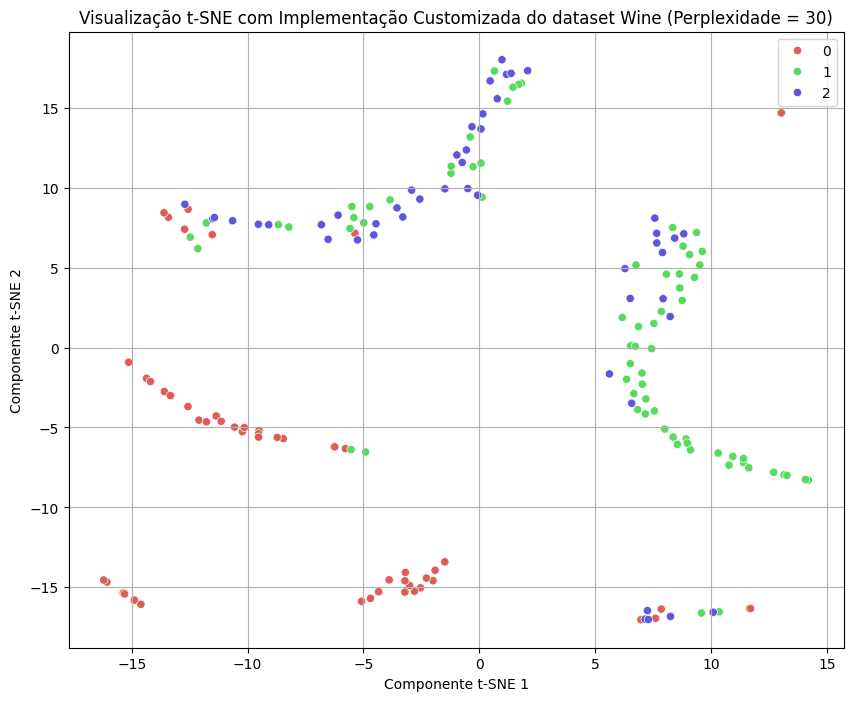

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.6726
Iter  200: cost = 0.5616
Iter  300: cost = 0.5130
Iter  400: cost = 0.4817
Iter  500: cost = 0.4512
Iter  600: cost = 0.4261
Iter  700: cost = 0.4152
Iter  800: cost = 0.4065
Iter  900: cost = 0.3992
Iter 1000: cost = 0.3923


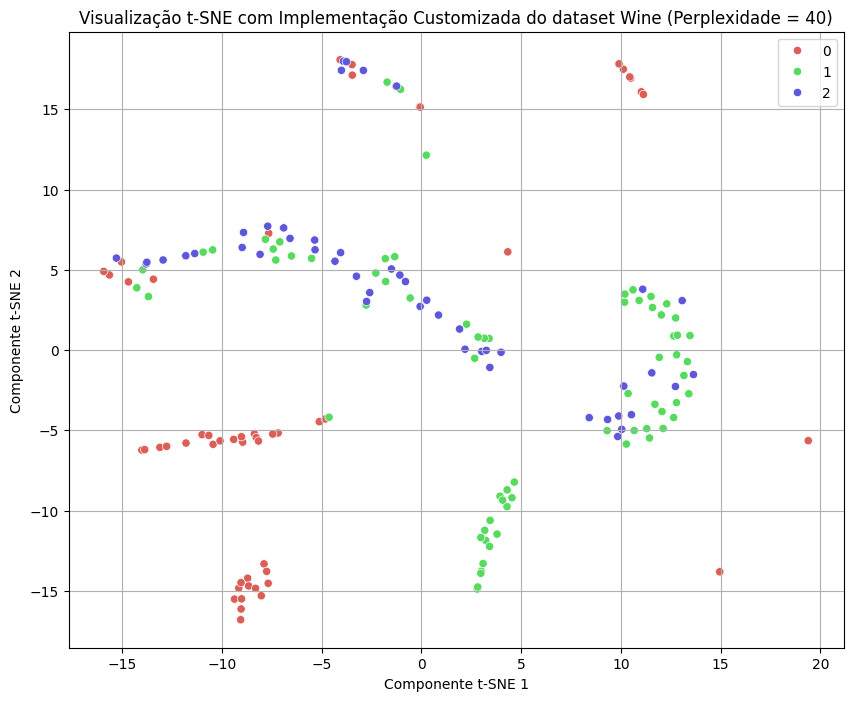

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7108
Iter  200: cost = 0.5509
Iter  300: cost = 0.4960
Iter  400: cost = 0.4526
Iter  500: cost = 0.4234
Iter  600: cost = 0.3987
Iter  700: cost = 0.3864
Iter  800: cost = 0.3781
Iter  900: cost = 0.3714
Iter 1000: cost = 0.3659


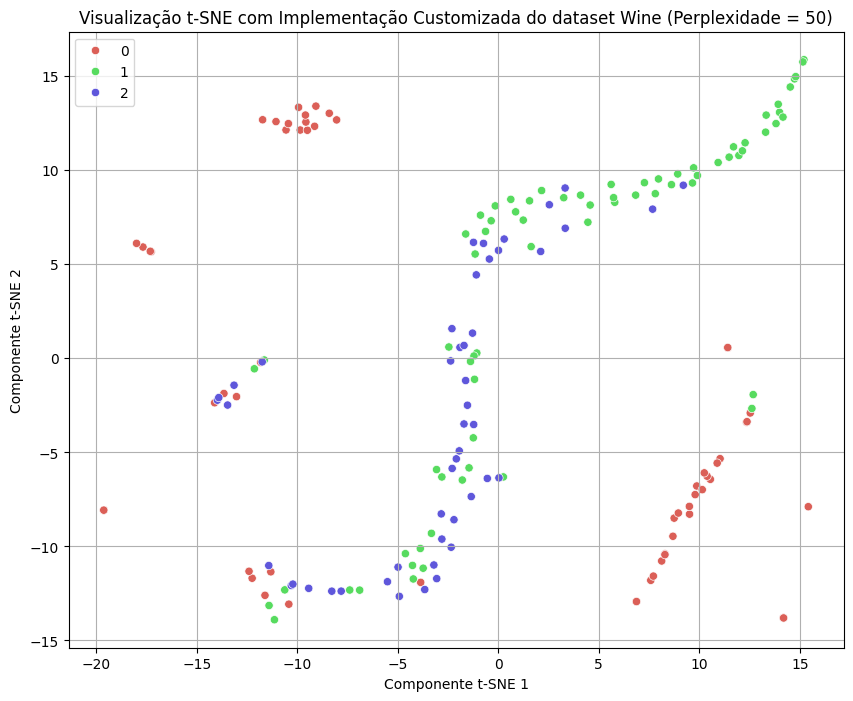

In [ ]:
perplexities = [5, 10, 20, 30, 40, 50]

for perplexity in perplexities:
    custom_tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, lr=200)
    X_embedded_custom = custom_tsne.fit_transform(X_wine)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y_wine,
    palette=sns.color_palette("hls", 3),
    legend="full")

    plt.title('Visualização t-SNE com Implementação Customizada do dataset Wine (Perplexidade = ' + str(perplexity) + ')')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.grid(True)
    plt.show()